In [20]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline
import math

sns.set_style("white")
plt.style.use('seaborn')
# sns.set_palette("white")

In [2]:
df_raw = pd.read_csv('../data/nj_ev_registrations_public.csv')
# df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.head()
df_raw['Make'].value_counts()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Tesla              156797
Toyota              30005
BMW                 24813
Ford                22150
Chevrolet           21926
Nissan               7660
Hyundai              7517
Honda                7467
Porsche              4663
Volvo                3937
Audi                 3219
Chrysler             2761
GEM                  2537
Kia                  2240
Mercedes             1944
Volkswagen           1654
Smart                1232
Mini                 1140
Jeep                 1138
Mitsubishi           1052
Subaru                970
Jaguar                730
Cadillac              470
Lincoln               320
Fiat                  277
Azure                 237
Polestar              232
Fisker                217
Land Rover            200
Miles                 126
E-Ride                 73
Proterra               48
Smith                  39
Karma                  25
Mclaren                25
Ferrari                10
Bentley                 9
Th!nk                   5
Workhorse   

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2017-06-30,9226.0
2017-12-31,14743.0
2018-06-30,17582.0
2018-12-31,22837.0
2019-06-30,26513.0
2019-12-31,30393.0
2020-06-30,34149.0
2020-12-31,41457.0
2021-06-30,49129.0


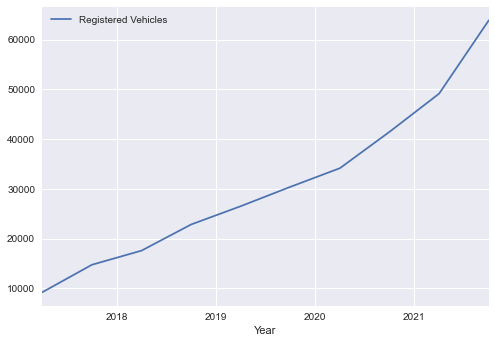

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Registered Vehicles'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

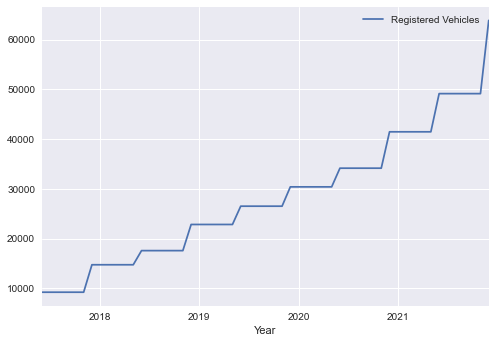

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(2.0411034434890856,
 0.9987240377348273,
 6,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 740.5961369456647)

## Modeling

In [9]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2017-06-30':'2020-12-31']
test = df['2021-06-30':]
combined = df

test

,Registered Vehicles
Year,
2021-06-30,49129.0
2021-07-31,49129.0
2021-08-31,49129.0
2021-09-30,49129.0
2021-10-31,49129.0
2021-11-30,49129.0
2021-12-31,63843.0


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=992.279, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=785.585, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=787.585, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=787.498, Time=0.10 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.882 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -389.793
Date:            

### The best model is :  ARIMA (1,0,1) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0287      0.007    143.461      0.000       1.015       1.043
ma.L1         -0.5949      0.168     -3.538      0.000      -0.924      -0.265
sigma2      3.422e+06   9.79e-09    3.5e+14      0.000    3.42e+06    3.42e+06


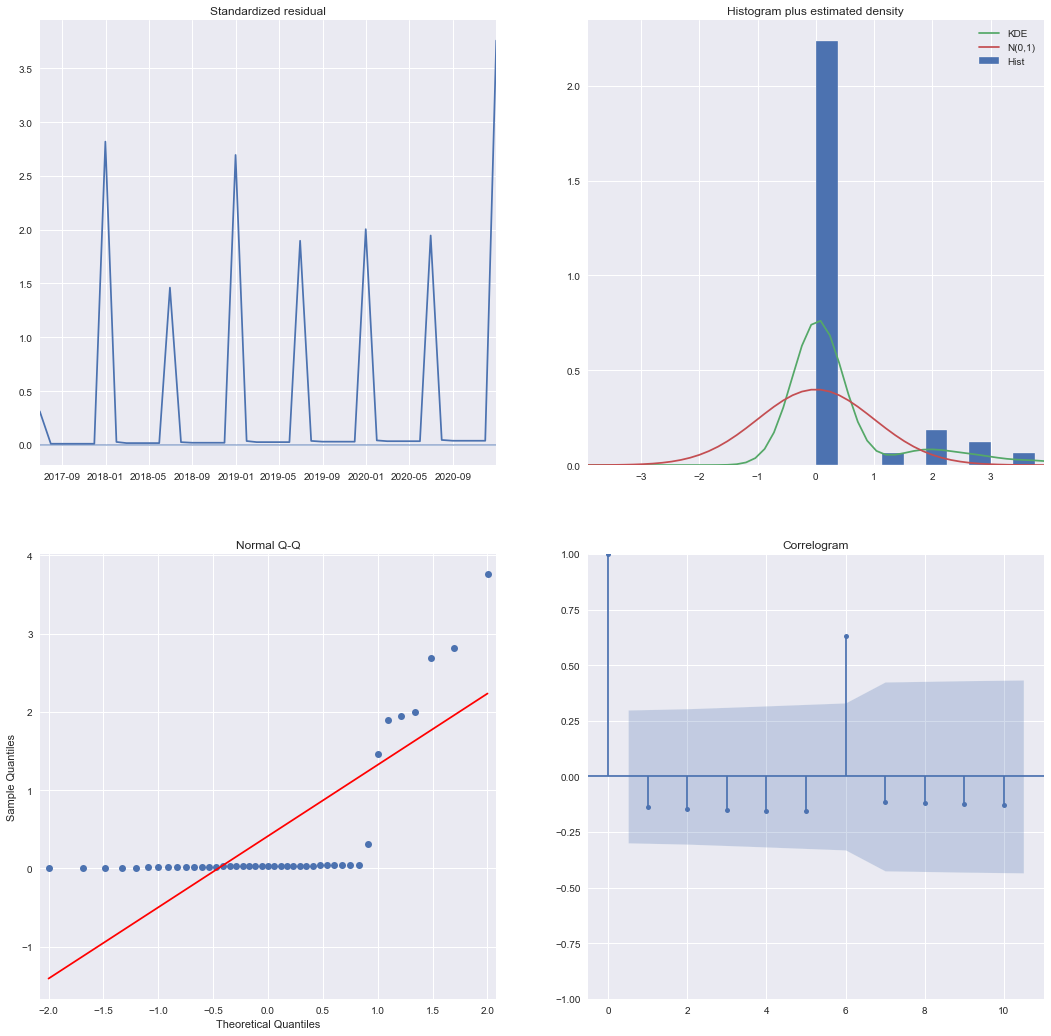

In [11]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [12]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2021-12-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-12-31,32755.899800,40007.564069
2021-01-31,36001.958861,43253.623129
2021-02-28,36812.914478,44717.575016
2021-03-31,37664.604040,46206.090618
2021-04-30,38555.363824,47722.707928
2021-05-31,39484.198027,49270.350811
2021-06-30,40450.565760,50851.543566
2021-07-31,41454.250817,52468.542735
2021-08-31,42495.278205,54123.422215
2021-09-30,43573.858569,55818.130508


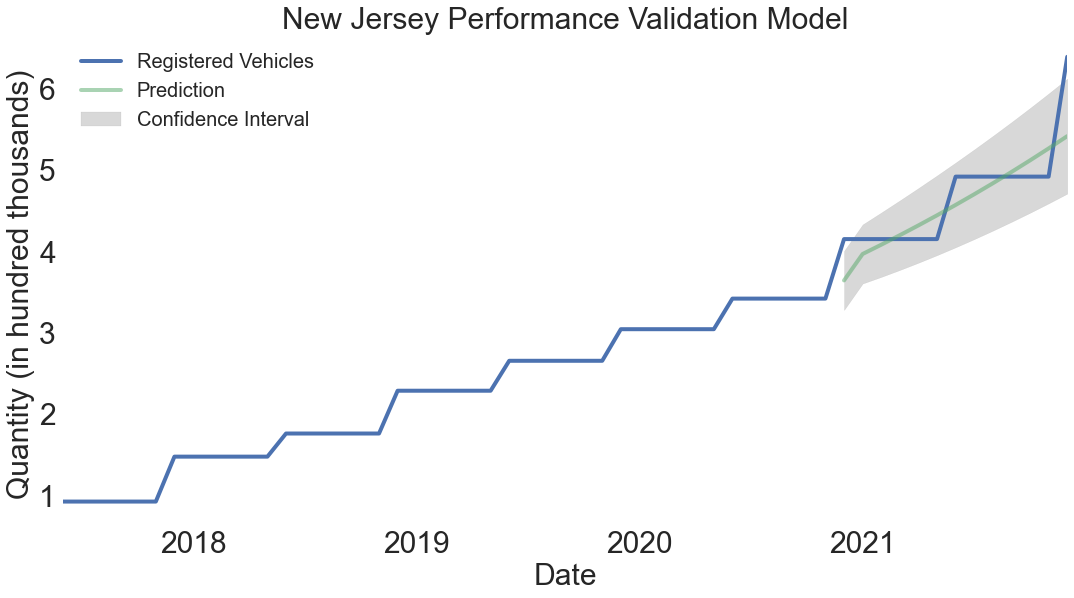

In [13]:

sns.set_style(style='white')
rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in hundred thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('New Jersey Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [14]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0287      0.007    143.461      0.000       1.015       1.043
ma.L1         -0.5949      0.168     -3.538      0.000      -0.924      -0.265
sigma2      3.422e+06   9.79e-09    3.5e+14      0.000    3.42e+06    3.42e+06


In [15]:
forecast = full_output.get_forecast(48)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2022-01-31,52572.746854,62888.175761,57730.461307
2022-02-28,54166.010266,64812.190223,59489.100245
2022-03-31,55808.065277,66794.559673,61301.312475
2022-04-30,57500.389563,68837.070431,63168.729997
2022-05-31,59244.506174,70941.562879,65093.034527
2022-06-30,61041.984891,73109.933126,67075.959008
2022-07-31,62894.443632,75344.134723,69119.289178
2022-08-31,64803.549904,77646.180432,71224.865168
2022-09-30,66771.022295,80018.144047,73394.583171
2022-10-31,68798.632013,82462.162264,75630.397138


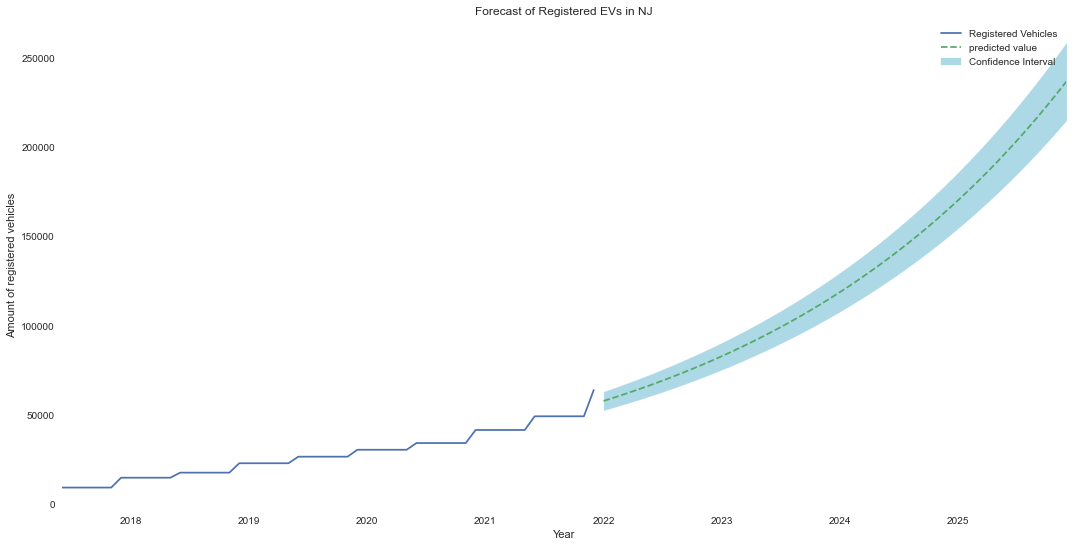

In [16]:
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Observed')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightblue',
                label='Confidence Interval')
scale_y = 1e6
ax.legend() 
plt.ylabel("Amount of registered vehicles")
plt.title('Forecast of Registered EVs in NJ')
plt.show()

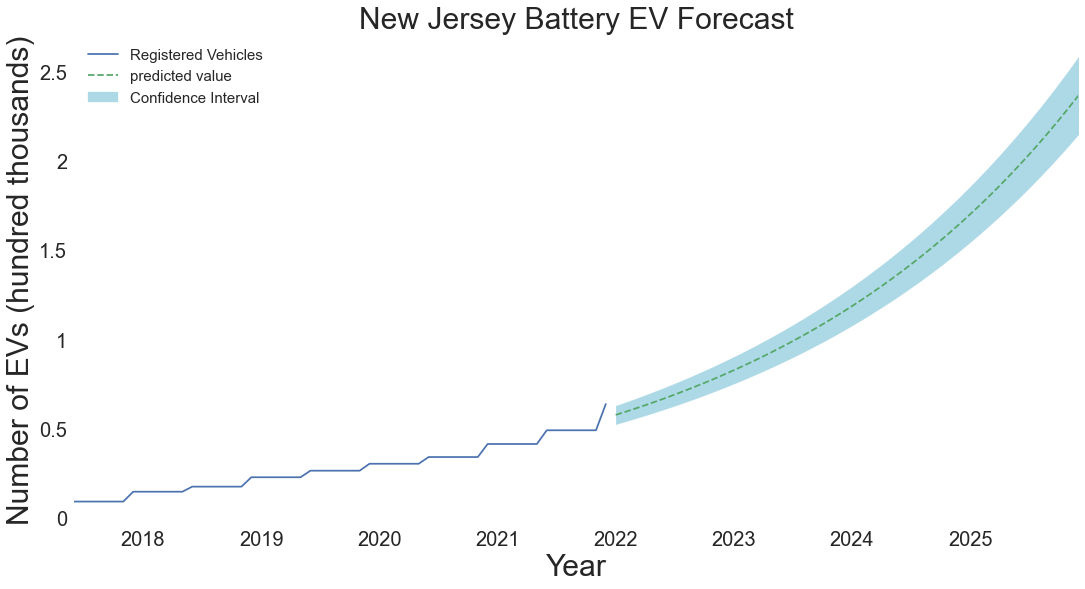

In [17]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs (hundred thousands)',fontsize=30)
plt.yticks(fontsize=20)

scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('New Jersey Battery EV Forecast',fontsize=30)
plt.legend(fontsize = 15)
plt.show()

In [23]:
MSE = mean_squared_error(test, pred_conf['lower Registered Vehicles'])
 
RMSE = math.sqrt(MSE)
print(RMSE)

ValueError: Found input variables with inconsistent numbers of samples: [7, 13]